# Ostensibly examining VCF files with pyvcf
### But really, accessing remote files and some bioinformatic dictionary usage

Objectives:

* access remote files with streams or by downloading
* practise scanning through a file, in this case record by record of VCF files
* use dictionaries both to access INFO fields and to generate summary data
* Compare across dictionaries

In [15]:
import vcf
import urllib.request
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

The version of pyvcf we're using here doesn't handle opening remote URLs as nicely as pandas does.  However,
it can take two types of input arguments; either something that looks like an open file, or a local filename.

`urllib` lets us deal with remote files with URLs very nicely in a couple of ways we'll look at:
scanning through the file, or just downloading it:

In [2]:
remote_readme_url = "ftp://ftp-trace.ncbi.nih.gov/giab/ftp/release/NA12878_HG001/latest/README.NIST.v2.19.txt"
remote_stream = urllib.request.urlopen(remote_readme_url) 
    
linecount = 0
for line in remote_stream:
    #print(line)
    print(line.decode('ascii'))
    linecount = linecount + 1
    if linecount > 3:
        break
        
remote_stream.close()

NIST Genome in a Bottle NA12878 vcf/bed file repository (www.genomeinabottle.org)



This is a repository of integrated snp and indel calls for NA12878, along with bed file that includes regions in which we believe our genotype calls are highly accurate (including homozygous reference calls if no snp or indel is called).  This is an updated version of our calls from Zook et al, Nat Biotech, 2014 (http://www.nature.com/nbt/journal/v32/n3/full/nbt.2835.html), which fixes a bug that caused more indels to be uncertain than necessary, so that these calls contain significantly more indels.  Otherwise, methods are similar to those described in the manuscript.





We can open such a stream with a vcf reader and get the header information:

In [3]:
remote_file_url = "ftp://ftp-trace.ncbi.nih.gov/giab/ftp/release/NA12878_HG001/latest/NISTIntegratedCalls_14datasets_131103_allcall_UGHapMerge_HetHomVarPASS_VQSRv2.19_2mindatasets_5minYesNoRatio_all_nouncert_excludesimplerep_excludesegdups_excludedecoy_excludeRepSeqSTRs_noCNVs.vcf.gz"
remote_stream = urllib.request.urlopen(remote_file_url)
    
v = vcf.Reader(remote_stream, compressed=True)

print('Variant Level information')
infos = v.infos
for info in infos:
    print(info)

print()
print('Sample Level information')
fmts = v.formats
for fmt in fmts:
    print(fmt)
    
remote_stream.close()

Variant Level information
AC
AF
AN
DP
DPSum
Entropy
HRun
HapNoVar
LEN
NoCG
NoPLTot
PL454WG
PLCG
PLHSWEx
PLHSWG
PLILL250
PLILLCLIA
PLILLWEx
PLILLWG
PLIllPCRFree
PLIonEx
PLPlatGen
PLXIll
PLXPSolWGLS
PLminsum
PLminsumOverDP
RPA
RU
TYPE
TrancheABQDmin2
TrancheAlignmin2
TrancheMapmin2
TrancheSSEmin2
YesPLtot
allalts
datasetcalls
filter
geno
genoMapGood
platformbias
platformnames
platforms
varType

Sample Level information
DP
GQ
GT
PL


But because we'll be scanning over this file repeatedly, let's get a subset of it locally:

In [4]:
chr20_filename="https://github.com/ljdursi/mon_py_wrkshp/blob/master/NISTIntegratedCalls_chr20.vcf.gz?raw=true"
localfilename="NIST_chr20.vcf.gz"
urllib.request.urlretrieve(chr20_filename, localfilename)

('NIST_chr20.vcf.gz', <http.client.HTTPMessage at 0x10fa732e8>)

Let's see what we can do with one of these files.  When we open a vcf file, we have to call a function `next` to get a record:

In [84]:
reader = vcf.Reader(filename=localfilename)
record = next(reader)
print(record)
print(record.POS)
print(record.INFO)
print(record.INFO['platformnames'])
print(record.samples)
print(record.samples[0]['GT'])

Record(CHROM=20, POS=61138, REF=C, ALT=[CT])
61138
{'varType': 'INDEL', 'YesPLtot': 7, 'DPSum': 571, 'TrancheMapmin2': 0.0, 'HapNoVar': 0, 'PLILLWG': ['133', '0', '108', '133', '133', '133'], 'PLHSWG': ['684', '0', '649', '684', '684', '684'], 'RU': 'T', 'TrancheAlignmin2': 0.0, 'platforms': 1, 'NoPLTot': 1, 'TrancheABQDmin2': 90.0, 'RPA': [12, 13], 'PLminsumOverDP': 7.31, 'geno': 2, 'platformnames': ['ill'], 'PLILL250': ['296', '0', '430', '430', '430', '430'], 'PLCG': ['6', '0', '100', '100', '100', '100'], 'TrancheSSEmin2': 90.0, 'allalts': ['CT', 'T'], 'PLILLCLIA': ['512', '0', '657', '657', '657', '657'], 'PLXIll': ['281', '0', '284', '284', '284', '284'], 'PLPlatGen': ['1922', '0', '2315', '2315', '2315', '2315'], 'HRun': 0, 'PLminsum': 4173, 'PLNCIIonWG': ['0', '127', '127', '18', '127', '127'], 'PLIllPCRFree': ['466', '0', '430', '466', '466', '466'], 'PLIonEx': ['filteredSSE99.9Align99.9', '0', '46', '46', '6', '46', '46'], 'platformbias': ['none'], 'datasetcalls': 10, 'genoMa

The usual way to process a file, VCF or otherwise, is to loop over lines in the file and process them as you like:

In [72]:
reader = vcf.Reader(filename=localfilename)
recordnum = 0
for record in reader:
    print(record, record.samples[0]['GT'], record.INFO['varType'], record.INFO['DPSum'])
    recordnum += 1
    if recordnum == 5:
        break

Record(CHROM=20, POS=61138, REF=C, ALT=[CT]) 0/1 INDEL 571 ['ill']
Record(CHROM=20, POS=67500, REF=T, ALT=[TTGGTATCTAG]) 0/1 INDEL 602 ['ill', '454', 'sol', 'cg', 'ion']
Record(CHROM=20, POS=68749, REF=T, ALT=[C]) 1/1 SNP 768 ['ill', '454', 'cg']
Record(CHROM=20, POS=70484, REF=CTCTT, ALT=[C]) 0/1 INDEL 671 ['ill', '454', 'sol', 'cg', 'ion']
Record(CHROM=20, POS=70980, REF=G, ALT=[A]) 0/1 SNP 799 ['ill', '454', 'cg', 'ion']


Hands-on: write a function, `get_depths`, which is given a filename and returns a list of all `DPSum` info fields - this is the total depth across all platforms at which this base was seen.

In [7]:
def get_depths(input_file):
    depth_counts = []
    depth_item = 'DPSum'
    reader = vcf.Reader(filename=input_file)
    for record in reader:
        if depth_item in record.INFO:
            depth = int(record.INFO[depth_item])
            depth_counts.append(depth)
    return depth_counts

In [8]:
depths = get_depths(localfilename)

(array([  5.00000000e+00,   7.00000000e+00,   1.30000000e+01,
          1.70000000e+01,   2.90000000e+01,   3.30000000e+01,
          6.00000000e+01,   9.60000000e+01,   1.05000000e+02,
          1.76000000e+02,   2.13000000e+02,   3.31000000e+02,
          4.50000000e+02,   5.55000000e+02,   8.07000000e+02,
          1.07400000e+03,   1.47600000e+03,   2.01000000e+03,
          2.66600000e+03,   3.63600000e+03,   5.19100000e+03,
          6.66000000e+03,   9.00000000e+03,   9.50300000e+03,
          9.59300000e+03,   7.85300000e+03,   5.22900000e+03,
          3.10800000e+03,   1.52900000e+03,   7.44000000e+02,
          3.66000000e+02,   1.54000000e+02,   1.08000000e+02,
          9.00000000e+01,   6.50000000e+01,   6.00000000e+01,
          5.20000000e+01,   4.60000000e+01,   3.20000000e+01,
          1.80000000e+01,   1.70000000e+01,   1.50000000e+01,
          3.00000000e+00,   5.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   2.00000000e+00,
        

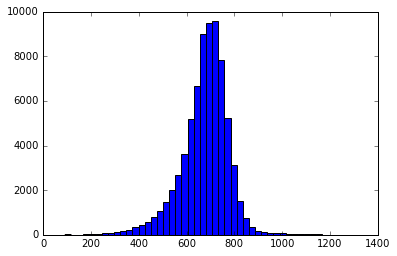

In [9]:
plt.hist(depths, bins=50)

TODO:

* Demonstrate: get counts as dictionary
    * defaultdict
* Hands on: generate defaultdict of counts by varianttype, genotype
* Generate list of dictionaries of calls by platform type; using those, investigate overlap and no-overlap of calls by platform.  Eg, how many calls were made by illumina that weren't made by 10x?

We'd actually like our data structured in a little more structured a way than just a list of counts - there's obviously a lot of variants with a depth of (say) 650, but how many?  A very useful way to tackle this question 
is with a dictionary.  How would we loop over the depths and generate a dictionary such that `depth_dict[320]` gave us the number of variants at depth 320?

In [16]:
depth_dict = {}
for depth in depths:
    if depth in depth_dict:
        depth_dict[depth] = depth_dict[depth] + 1
    else:
        depth_dict[depth] = 1

print(depth_dict)
print(list(depth_dict.keys())[:5])
print(list(depth_dict.values())[:5])
print(list(depth_dict.items())[:5])
print(min(depth_dict.keys()), max(depth_dict.keys()))

{92: 1, 101: 1, 114: 1, 115: 1, 116: 1, 123: 1, 131: 1, 133: 1, 134: 1, 135: 1, 138: 2, 146: 1, 147: 1, 148: 1, 150: 1, 154: 2, 156: 1, 157: 1, 159: 1, 161: 1, 162: 1, 163: 1, 168: 1, 170: 1, 174: 2, 177: 1, 178: 1, 179: 1, 181: 2, 182: 1, 185: 1, 186: 1, 187: 1, 189: 1, 191: 2, 192: 1, 193: 1, 195: 1, 196: 1, 197: 1, 198: 2, 200: 1, 202: 2, 203: 1, 205: 1, 206: 2, 208: 1, 209: 3, 211: 4, 214: 3, 216: 1, 217: 2, 218: 2, 220: 1, 222: 2, 224: 1, 226: 3, 227: 1, 228: 2, 229: 2, 231: 2, 232: 2, 233: 1, 234: 1, 235: 2, 236: 2, 237: 2, 238: 2, 239: 1, 241: 4, 242: 1, 245: 2, 249: 1, 250: 3, 251: 3, 252: 5, 253: 1, 254: 2, 255: 1, 256: 1, 257: 4, 259: 4, 260: 2, 262: 5, 264: 6, 265: 2, 267: 4, 268: 3, 269: 6, 270: 3, 271: 4, 272: 7, 273: 5, 274: 3, 275: 4, 276: 4, 277: 4, 278: 5, 279: 1, 280: 4, 281: 3, 282: 2, 283: 4, 285: 5, 286: 4, 287: 5, 289: 3, 290: 5, 291: 7, 292: 2, 293: 5, 294: 6, 295: 7, 296: 1, 297: 4, 298: 1, 299: 8, 300: 5, 301: 4, 302: 4, 303: 2, 304: 8, 305: 3, 306: 6, 307: 6, 

How would we get a sorted list of depths, and the counts associated, to plot?


In [19]:
depths = sorted(depth_dict.keys())
counts = [depth_dict[depth] for depth in depths]

In [35]:
items = sorted(depth_dict.items())
depths = []
counts = []
for item in items:
    depths.append(item[0])
    counts.append(item[1])

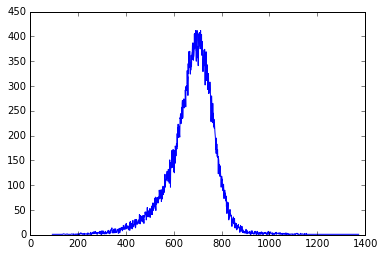

In [36]:
plt.plot(depths, counts)

Some of that dictionary handling was more awkward than we'd like because we can't access a dictionary entry that
doesn't exist yet.  In the line `depth_dict[depth] = depth_dict[depth] + 1`, `depth_dict[depth]` for a new depth is,
reasonably, an error.  We could fix that if there was a default value.

In the `collections` module, which has a lot of neat data structures, there's a `defaultdict` type which generates an empty dictionary with a given type, that provides a sensible default for that type.  A `defaultdict(int)` has 
a default value of 0 for new items, a `defaultdict(list) or (set)` has default values of an empty list or set, etc.

This makes counting much easier:

In [39]:
import collections
depth_dict = collections.defaultdict(int)

for depth in depths:
    depth_dict[depth] = depth_dict[depth] + 1

In [40]:
print(list(depth_dict.keys())[:5])

[92, 101, 114, 115, 116]


Hands on: given the name of a VCF file, write functions which generate defaultdict of counts by varianttype, genotype

In [63]:
def variant_type_counts(input_file):
    type_counts = collections.defaultdict(int)
    type_item = 'varType'
    reader = vcf.Reader(filename=input_file)
    for record in reader:
        if type_item in record.INFO:
            vartype = record.INFO[type_item]
            type_counts[vartype] += 1
    return type_counts

def genotype_counts(input_file):
    type_counts = collections.defaultdict(int)
    type_item = 'GT'
    reader = vcf.Reader(filename=input_file)
    for record in reader:
        for sample in record.samples:
            gt = sample[type_item]
            type_counts[gt] += 1
    return type_counts

In [46]:
vt_counts = variant_type_counts(localfilename)

In [48]:
print(vt_counts)
for vartype in vt_counts:
    print(vartype, vt_counts[vartype])

defaultdict(<class 'int'>, {'SNP': 64150, 'INDEL': 9063})
SNP 64150
INDEL 9063


In [64]:
gt_counts = genotype_counts(localfilename)
print(gt_counts)
for gt in gt_counts:
    print(gt, gt_counts[gt])

defaultdict(<class 'int'>, {'1/1': 26527, '1|2': 88, '3|2': 17, '2|1': 79, '1|0': 1, '3|1': 1, '2|3': 10, '1|3': 2, '0|1': 1, '0/1': 46686})
1/1 26527
1|2 88
3|2 17
2|1 79
1|0 1
3|1 1
2|3 10
1|3 2
0|1 1
0/1 46686


In [81]:
def get_all_platforms(input_file):
    list_of_platforms = []
    reader = vcf.Reader(filename=input_file)
    info_field='platformnames'
    for record in reader:
        if info_field in record.INFO:
            for platform in record.INFO[info_field]:
                if not platform in list_of_platforms:
                    list_of_platforms.append(platform)
        linenum += 1
    return list_of_platforms

In [82]:
platform_names = get_all_platforms(localfilename)

In [83]:
print(platform_names)

['ill', '454', 'sol', 'cg', 'ion']


Let's try to compare how the illiumina and 454 data agree or not on variants.  To do this, we'll get a dictionary of illumina variants, a dictionary of 454 variants, and see how they overlap.

How are we going to treat variants as a dictionary?  Since we're only looking at one chromosome, there's only one position which matters: the position on chr20.  But there's many possible variants at that position: the (ref, alt) pair uniquely defines a variant at that position.

So that's what we'll do: we'll create a dictionary of dict[position] = [... (ref,alt) ].

In [90]:
def variant_dict_by_platform(input_file, platform='ill'):
    variant_dict = collections.defaultdict(list)

    reader = vcf.Reader(filename=input_file)
    info_field='platformnames'
    for record in reader:
        if info_field in record.INFO:
            if platform in record.INFO[info_field]:
                for alt in record.ALT:
                    variant_dict[record.POS].append( (record.REF, str(alt)) )
    return variant_dict

In [94]:
illumina = variant_dict_by_platform(localfilename)

In [92]:
roche = variant_dict_by_platform(localfilename, '454')

In [93]:
print(list(illumina.items())[:5])
print(list(roche.items())[:5])

[(15990784, [('C', T)]), (2621442, [('C', T)]), (3014659, [('G', A)]), (4980740, [('C', T)]), (23592966, [('C', A)])]
[(15990784, [('C', 'T')]), (3014659, [('G', 'A')]), (4980740, [('C', 'T')]), (23592966, [('C', 'A')]), (50397185, [('G', 'A')])]


In [102]:
def number_variants(vardict):
    nvariants = 0
    for pos in vardict:
        nvariants += len(vardict[pos])
    return nvariants

def compare_variant_dicts(vardict1, vardict2):
    only_in_1 = 0
    in_both = 0
    for posn in vardict1:
        for variant in vardict1[posn]:
            if not posn in vardict2:
                only_in_1 += 1
            elif variant not in vardict2[posn]:
                only_in_1 += 1
            else:
                in_both += 1
    
    only_in_2 = number_variants(vardict2) - in_both
    
    return only_in_1, in_both, only_in_2

In [97]:
number_variants(illumina)

73213

In [98]:
number_variants(roche)

62000

In [103]:
compare_variant_dicts(illumina, roche)

(11213, 62000, 0)

Hands on:

* Try the other platforms and see how others compare
* Generate a dictionary-of-dictionaries for all platforms, and do an all-vs-all comparison